In [1]:
import nomic
import json
nomic.login("nk-2LSEn5FB5h04Dn0pFLuZ9jDw7ZaMbPpYPV88wbKKASc")
#- Scientific programming
import numpy as np
import pandas as pd
from tqdm import tqdm

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime

dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-06-10')

embds = dataset.maps[0].embeddings.latent
df = dataset.maps[0].data.df

tags_df = dataset.maps[0].tags.df

df = df.merge(tags_df, on='tweetId')
df.head()

/Users/tianyichen/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2024-06-11 16:03:56.715 | INFO     | nomic.dataset:__init__:829 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-06-10`.
100%|██████████| 125/125 [00:00<00:00, 263.95it/s]


,name,party,twitter_lower,years,chamber,state,postedAt,source,tweetId,<115><2017><senate><179>,<118><2024><house><142>
0,Josh Gottheimer D-NJ,D,repjoshg,2021_2022,House,NJ,2022-05-29 13:22:24.171,PolitWoops,1530902377196314624,False,False
1,Ed Markey D-MA,D,senmarkey,2011_2012,Senate,MA,2011-05-13 21:06:26.255,PolitWoops,69146505528868864,False,False
2,Debbie Stabenow D-MI,D,senstabenow,2021_2022,Senate,MI,2022-03-02 01:14:27.293,PolitWoops,1498829050919411712,False,False
3,Ted Cruz R-TX,R,sentedcruz,2019_2020,Senate,TX,2019-10-31 16:48:33.055,PolitWoops,1189947274526384128,False,False
4,Dan Bishop R-NC,R,repdanbishop,2021_2022,House,NC,2021-08-25 00:15:49.917,PolitWoops,1430322991376834560,False,False


In [134]:
data_path = '/Users/tianyichen/Desktop/Research /PhDresearch/Twitters/congressional-twin/data/congress_votes/congress_votes_115-2017_s179.csv'
file_name = data_path.split('congress_votes_')[-1].split('.csv')[0]

temp_ = pd.read_csv(data_path)
vote_info_str = list(temp_.columns)[0]

pattern = r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}'
datetime_regex = re.compile(pattern)
match = datetime_regex.search(vote_info_str)

vote_datetime_obj = datetime.datetime.strptime(match.group(), '%Y-%m-%dT%H:%M:%S')

In [137]:
tag_name = '<115><2017><senate><179>'

congress_name_list = np.unique(list(df['name']))
congress_name_list = list(congress_name_list)

tweets_per_congress_person = {
    'global': np.zeros(len(congress_name_list)),
    'issue-specific': np.zeros(len(congress_name_list))
}

average_embds = {
    'global': np.zeros((len(congress_name_list), embds.shape[1])),
    'issue-specific': np.zeros((len(congress_name_list), embds.shape[1]))
}
 
congress_handles = [list(df['twitter_lower'][df['name'] == cn])[0] for cn in congress_name_list] #selects the rows in the DataFrame df where the 'name' column equals cn, and then it gets the 'twitter_lower' column of those rows.
party_by_congress_person = [-1 for cp in congress_name_list]

for i, embd in enumerate(tqdm(embds)):
    congress_name_index = congress_name_list.index(df['name'][i])
    time_posted = df['postedAt'][i].to_pydatetime()

    if vote_datetime_obj < time_posted: #if the tweet is poseted after the vote, skips this tweet
        continue

    tweets_per_congress_person['global'][congress_name_index] += 1
    average_embds['global'][congress_name_index] += embd

    if df[tag_name][i]:
        tweets_per_congress_person['issue-specific'][congress_name_index] += 1
        average_embds['issue-specific'][congress_name_index] += embd

    if party_by_congress_person[congress_name_index] == -1:
        party_by_congress_person[congress_name_index] = df['party'][i].lower()

average_embds = {k: np.divide(average_embds[k],  tweets_per_congress_person[k].reshape(-1, 1)) for k in average_embds}
unique_party_labels, party_counts = np.unique(party_by_congress_person, return_counts=True)

100%|██████████| 2904271/2904271 [01:40<00:00, 28810.15it/s]
/var/folders/rl/pr6f4j2d1_5913_lglcbwszc0000gn/T/ipykernel_3517/206310114.py:36: RuntimeWarning: invalid value encountered in true_divide
  average_embds = {k: np.divide(average_embds[k],  tweets_per_congress_person[k].reshape(-1, 1)) for k in average_embds}


In [138]:
# store everything into a dataframe with each row for a congress person, it has redundant columns. 
data = {'twitter_lower': congress_handles, 'congress_name_list': congress_name_list}

df_congress = pd.DataFrame(data)
df_congress['average_embds_global'] = average_embds['global'].tolist()
df_congress['average_embds_issue_specific'] = average_embds['issue-specific'].tolist()

df_congress = df_congress.merge(df.drop_duplicates(subset='twitter_lower'), on='twitter_lower', how='left') ## ignore the column <115><2017><senate><179> and <118><2024><house><142>
df_congress.head()

,twitter_lower,congress_name_list,average_embds_global,average_embds_issue_specific,name,party,years,chamber,state,postedAt,source,tweetId,<115><2017><senate><179>,<118><2024><house><142>
0,repfinkenauer,Abby Finkenauer D-IA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Abby Finkenauer D-IA,D,2019_2020,House,IA,2020-06-18 15:00:50.141,PolitWoops,1273631764053987328,False,False
1,repspanberger,Abigail Spanberger D-VA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Abigail Spanberger D-VA,D,2021_2022,House,VA,2022-04-16 14:37:39.608,PolitWoops,1515338638091030528,False,False
2,repkinzinger,Adam Kinzinger R-IL,"[0.0025755441793512543, 0.03735162318019932, -...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Adam Kinzinger R-IL,R,2017_2018,House,IL,2018-11-15 16:25:46.373,PolitWoops,1063105789286666240,False,False
3,repadamschiff,Adam Schiff D-CA,"[0.013665779320078302, 0.04313013124946939, -0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Adam Schiff D-CA,D,2019_2020,House,CA,2019-11-19 20:26:15.846,PolitWoops,1196887433289359360,False,False
4,repadamsmith,Adam Smith D-WA,"[0.007752102992591068, 0.039345022886109776, -...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Adam Smith D-WA,D,2017_2018,House,WA,2018-08-01 20:44:57.706,PolitWoops,1024757902551261184,False,False


In [139]:
file_name = data_path.split('congress_votes_')[-1].split('.csv')[0]
 
df_vote_result = pd.read_csv(data_path, header=1)

df_vote_result.head()

,person,state,district,vote,name,party
0,300002,TN,NaN,Yea,"Sen. Lamar Alexander [R, 2003-2020]",Republican
1,300018,WA,NaN,Nay,"Sen. Maria Cantwell [D, 2001-2024]",Democrat
2,300019,DE,NaN,Nay,"Sen. Thomas Carper [D, 2001-2024]",Democrat
3,300023,MS,NaN,Yea,"Sen. Thad Cochran [R, 1979-2018]",Republican
4,300025,ME,NaN,Nay,"Sen. Susan Collins [R, 1997-2026]",Republican


In [140]:
df_vote_result['matched-name'] = ''
df_vote_result['twitter-handle'] = ''
df_vote_result['average-embd-global'] = ''
df_vote_result['average-embd-issue-specific'] = ''
df_vote_result['matched-state'] = ''

for i, row in df_vote_result.iterrows():
    name = unidecode(row['name'].split(' [')[0].split('Sen. ')[1])
    party_val = row['party'][0]
    state_val = row['state']
    candidate_names = df_congress.loc[(df_congress['party'] == party_val) & (df_congress['state'] == state_val), 'congress_name_list'].apply(unidecode)
    name_parts = name.split(" ")

    for napa in name_parts:
        if candidate_names.str.contains(napa).any():
            index = candidate_names[candidate_names.str.contains(napa)].index[0]


            df_vote_result.at[i, 'matched-name'] = df_congress.loc[index]['congress_name_list']
            df_vote_result.at[i, 'average-embd-global'] = df_congress.loc[index]['average_embds_global']
            df_vote_result.at[i, 'twitter-handle'] = df_congress.loc[index]['twitter_lower']
            df_vote_result.at[i, 'matched-party']=df_congress.loc[index]['party']
            df_vote_result.at[i, 'matched-state']=df_congress.loc[index]['state']

            if np.isnan(average_embds['issue-specific'][index][0]):
                #df_vote_result.at[i, 'average-embd-issue-specific'] = df_congress.loc[index]['average_embds_issue_specific']
                df_vote_result.at[i, 'average-embd-issue-specific'] = np.nan
            else:
                df_vote_result.at[i, 'average-embd-issue-specific'] = df_congress.loc[index]['average_embds_issue_specific']
                #df_vote_result.at[i, 'average-embd-issue-specific'] = np.nan
        else:
            df_vote_result.at[i, 'matched-name'] = np.nan
            #df_vote_result.at[i, 'average-embd'] = np.nan
            df_vote_result.at[i, 'twitter-handle'] = np.nan
            df_vote_result.at[i, 'matched-party']=np.nan
            df_vote_result.at[i, 'matched-state']=np.nan
            df_vote_result.at[i, 'average-embd-issue-specific'] = np.nan

df_vote_result.head()

,person,state,district,vote,name,party,matched-name,twitter-handle,average-embd-global,average-embd-issue-specific,matched-state,matched-party
0,300002,TN,NaN,Yea,"Sen. Lamar Alexander [R, 2003-2020]",Republican,Lamar Alexander R-TN,senalexander,"[0.009264346055505097, 0.04242450703633876, -0...","[0.009686428719124366, 0.0467718743829986, -0....",TN,R
1,300018,WA,NaN,Nay,"Sen. Maria Cantwell [D, 2001-2024]",Democrat,"Cantwell, Maria",senatorcantwell,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,WA,D
2,300019,DE,NaN,Nay,"Sen. Thomas Carper [D, 2001-2024]",Democrat,"Carper, Thomas",senatorcarper,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,DE,D
3,300023,MS,NaN,Yea,"Sen. Thad Cochran [R, 1979-2018]",Republican,Thad Cochran R-MS,senthadcochran,"[0.01546081527114829, 0.030818887950514285, -0...","[0.017809977192850508, 0.050288344276021926, -...",MS,R
4,300025,ME,NaN,Nay,"Sen. Susan Collins [R, 1997-2026]",Republican,"Collins, Susan",senatorcollins,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,ME,R


In [9]:
df_vote_result.dropna(inplace=True)
df_vote_result.to_csv(f'/Users/tianyichen/Desktop/Research /PhDresearch/Twitters/congressional-twin/experiments/tianyi/{file_name}.csv')


,person,state,district,vote,name,party,matched-name,twitter-handle,average-embd-global,average-embd-issue-specific,matched-state,matched-party
0,400004,AL,4,Yea,Rep. Robert Aderholt [R],Republican,"Aderholt, Robert",robert_aderholt,"[0.017503820146833146, 0.03896857670375279, -0...","[0.006040811538696289, 0.042439937591552734, -...",AL,R
1,400030,GA,2,Not Voting,Rep. Sanford Bishop [D],Democrat,"Bishop Jr., Sanford",sanfordbishop,"[0.018433302640914917, 0.049648284912109375, -...","[0.017269134521484375, 0.0095062255859375, -0....",GA,D
3,400052,TX,26,Yea,Rep. Michael Burgess [R],Republican,"Burgess, Michael",michaelcburgess,"[0.021851594874400967, 0.05065598708904342, -0...","[0.02545155649599822, 0.08420595915421196, -0....",TX,R
4,400057,CA,41,Yea,Rep. Ken Calvert [R],Republican,"Calvert, Ken",kencalvert,"[0.018314135260879993, 0.05678512156009674, -0...","[0.020268772777758147, 0.06673792788856908, -0...",CA,R
5,400068,TX,31,Yea,Rep. John R. Carter [R],Republican,"Carter, John",judgecarter,"[0.02061185469994178, 0.0426945319542518, -0.1...","[0.030901227678571428, 0.078216552734375, -0.1...",TX,R
...,...,...,...,...,...,...,...,...,...,...,...,...
424,456948,VT,0,Nay,Rep. Becca Balint [D],Democrat,"Balint, Becca",repbeccab,"[0.01495241103734512, 0.05949697952603669, -0....","[0.010616219562032948, 0.061879697053328804, -...",VT,D
425,456949,WA,3,Yea,Rep. Marie Gluesenkamp Perez [D],Democrat,"Perez, Marie",repmgp,"[0.00741544267633459, 0.04133862191504174, -0....","[0.017009735107421875, 0.0482389662000868, -0....",WA,D
426,456950,WI,3,Yea,Rep. Derrick Van Orden [R],Republican,"Van Orden, Derrick",repvanorden,"[0.014628310262421031, 0.04565446465103715, -0...","[0.019644056047712053, 0.05946895054408482, -0...",WI,R
427,456951,WY,0,Nay,Rep. Harriet Hageman [R],Republican,"Hageman, Harriet",rephageman,"[0.01823613201220011, 0.05706765479648236, -0....","[0.02367426554361979, 0.07461954752604166, -0....",WY,R


In [142]:
average_embd_global = np.array([np.array(d) for d in df_vote_result['average-embd-global'].values])
average_embd_issue_specific = np.array([np.array(d) for d in df_vote_result['average-embd-issue-specific'].values])

vote = [v for v in df_vote_result['vote'].values]
party = [p for p in df_vote_result['matched-party'].values]

/var/folders/rl/pr6f4j2d1_5913_lglcbwszc0000gn/T/ipykernel_3517/3270011360.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  average_embd_global = np.array([np.array(d) for d in df_vote_result['average-embd-global'].values])
/var/folders/rl/pr6f4j2d1_5913_lglcbwszc0000gn/T/ipykernel_3517/3270011360.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  average_embd_issue_specific = np.array([np.array(d) for d in df_vote_result['average-embd-issue-specific'].values])


In [143]:
from graspologic.embed import ClassicalMDS

cmds = ClassicalMDS(n_components=20)
cmds_embds = cmds.fit_transform(average_embd_global)
cmds.singular_values_


ValueError: setting an array element with a sequence.

In [35]:
vote_inds = []
y = []
for i, v in enumerate(vote):
    if v.lower() == 'nay':
        y.append(0)
    elif v.lower() == 'yea':
        y.append(1)
    else:
        continue
    vote_inds.append(i)    
vote_inds = np.array(vote_inds) ## exclude the not voting 


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score as bas

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
vote_str = '118-2024_h142'

Text(0.5, 1.02, 'Efficacy of representation+LogR with global embd\n for 118-2024_h142')

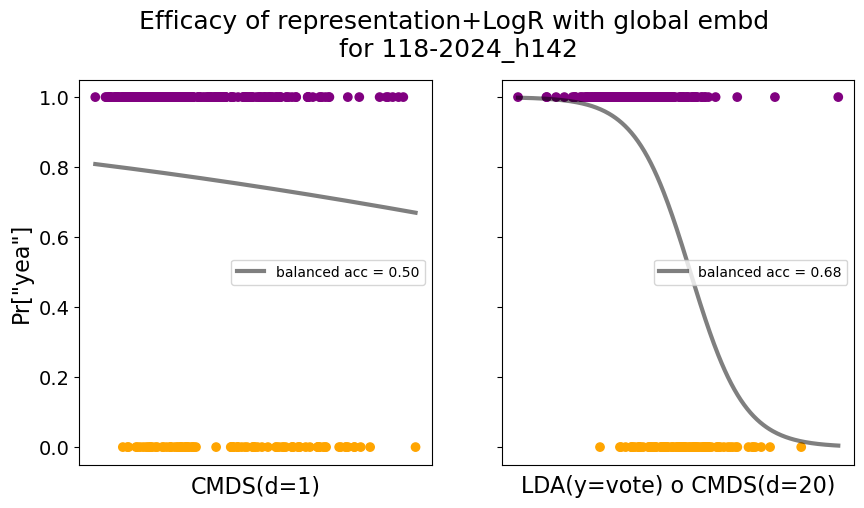

In [82]:

fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

cmds_embds = cmds.fit_transform(average_embd_global)


x = cmds_embds[vote_inds,:1]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[0].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel('CMDS(d=1)', fontsize=16)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(vote)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel(f'LDA(y=vote) o CMDS(d={cmds_embds.shape[1]})', fontsize=16)

for ax_ in ax:
    ax_.set_xticks([])
    ax_.tick_params(labelsize=14)

fig.suptitle(f'Efficacy of representation+LogR with global embd\n for {vote_str}', fontsize=18, y=1.02)

In [43]:
cmds_embds = cmds.fit_transform(average_embd_issue_specific)
cmds.singular_values_

array([1.93668805, 1.63645919, 1.30901512, 1.00856943, 0.92261489,
       0.82405469, 0.79316456, 0.76237597, 0.73661586, 0.72664483,
       0.69822798, 0.67521876, 0.63772731, 0.61995383, 0.60907847,
       0.59633691, 0.57450145, 0.54243119, 0.52329009, 0.50589183])

Text(0.5, 1.02, 'Efficacy of representation+LogR with issue_specific \n for 118-2024_h142')

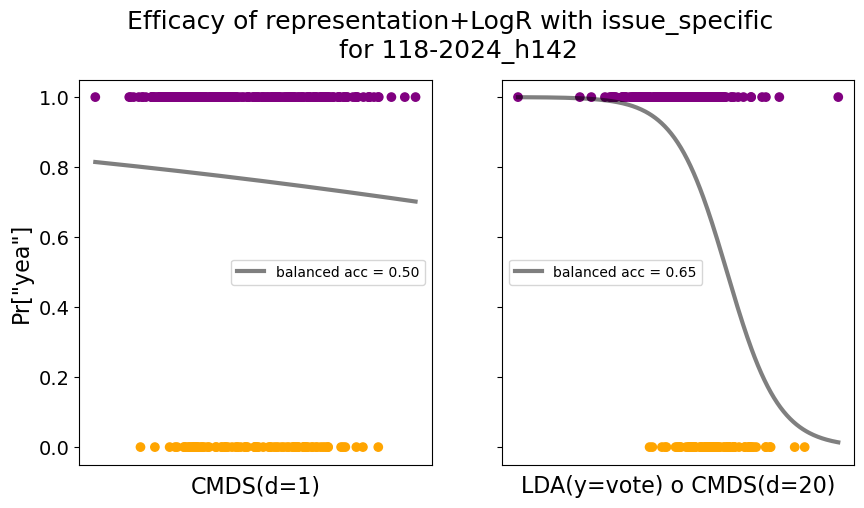

In [83]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

cmds_embds = cmds.fit_transform(average_embd_issue_specific)

x = cmds_embds[vote_inds,:1]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[0].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel('CMDS(d=1)', fontsize=16)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(vote)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel(f'LDA(y=vote) o CMDS(d={cmds_embds.shape[1]})', fontsize=16)

for ax_ in ax:
    ax_.set_xticks([])
    ax_.tick_params(labelsize=14)

fig.suptitle(f'Efficacy of representation+LogR with issue_specific \n for {vote_str}', fontsize=18, y=1.02)

In [132]:
from sklearn.manifold import Isomap

# Create an instance of Isomap with n_components=1
#isomap = Isomap(n_components=200)

# Fit and transform the average_embd_issue_specific array
#x = isomap.fit_transform(average_embd_global)[vote_inds,:] 
#x = isomap.fit_transform(average_embd_issue_specific)[vote_inds,:]  

cmds_embds = cmds.fit_transform(average_embd_issue_specific)

x = cmds_embds[vote_inds,:300]


vote_model = LogisticRegression()
vote_model.fit(x, y)

bas(y, vote_model.predict(x))


0.5

In [65]:
x = average_embd_issue_specific[vote_inds,:]

vote_model = LogisticRegression()
vote_model.fit(x, y)

#er = bas(y, vote_model.predict(x))
accuracy_score(y, vote_model.predict(x))
vote_model.predict_proba(x)

array([[0.26016137, 0.73983863],
       [0.25928695, 0.74071305],
       [0.25138659, 0.74861341],
       [0.28096316, 0.71903684],
       [0.21501954, 0.78498046],
       [0.27265037, 0.72734963],
       [0.24718208, 0.75281792],
       [0.20261708, 0.79738292],
       [0.2128165 , 0.7871835 ],
       [0.24480229, 0.75519771],
       [0.23151611, 0.76848389],
       [0.2062293 , 0.7937707 ],
       [0.34290333, 0.65709667],
       [0.21154668, 0.78845332],
       [0.32248206, 0.67751794],
       [0.22959653, 0.77040347],
       [0.209828  , 0.790172  ],
       [0.2221744 , 0.7778256 ],
       [0.20132694, 0.79867306],
       [0.21296118, 0.78703882],
       [0.27378224, 0.72621776],
       [0.21652962, 0.78347038],
       [0.19612421, 0.80387579],
       [0.2276512 , 0.7723488 ],
       [0.22591223, 0.77408777],
       [0.20624075, 0.79375925],
       [0.21322132, 0.78677868],
       [0.20306722, 0.79693278],
       [0.21051655, 0.78948345],
       [0.22906405, 0.77093595],
       [0.